In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# 載入資料

In [2]:
#載入資料
loans = pd.read_csv('accepted_2007_to_2017.csv', encoding='utf-8')
#loans = pd.read_csv('LoansData_sample.csv.gz', compression='gzip', encoding='utf-8')
dataset = loans

C:\Users\陳浩軒\AppData\Local\Temp\ipykernel_20648\1044495436.py:2: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  loans = pd.read_csv('accepted_2007_to_2017.csv', encoding='utf-8')


# 資料準備與特徵選擇

In [3]:
#資料大小
dataset.shape

(1646801, 150)

In [4]:
dataset

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646796,66141895,NaN,14400.0,14400.0,14400.0,60 months,13.18,328.98,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1646797,65673209,NaN,34050.0,34050.0,34050.0,36 months,15.41,1187.21,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1646798,65744272,NaN,5000.0,5000.0,5000.0,36 months,11.22,164.22,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1646799,Total amount funded in policy code 1: 2087217200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## 準備目標變數

In [6]:
#loan_status為目標變數，檢視分布情形
dataset['loan_status'].value_counts(dropna=False)

loan_status
Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: count, dtype: int64

In [7]:
#將目標變數鎖定在Fully Paid、Charged Off兩種狀態，並檢視分布
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]
dataset['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid     0.793758
Charged Off    0.206242
Name: proportion, dtype: float64

In [8]:
dataset['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid     0.793758
Charged Off    0.206242
Name: proportion, dtype: float64

79%的全額付清與21%已轉呆帳，資料稍微不平衡

In [9]:
#將全額付清轉為0，已轉呆帳轉為1，轉成新欄位
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)

#丟棄原本舊欄位
dataset.drop('loan_status', axis=1, inplace=True)

In [10]:
dataset['charged_off'].value_counts(dropna=False)

charged_off
0    646902
1    168084
Name: count, dtype: int64

## 特徵選擇

In [11]:
#查看個欄位缺失值狀況
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
missing_fractions

next_pymnt_d                                  1.000000
member_id                                     1.000000
orig_projected_additional_accrued_interest    0.999876
sec_app_mths_since_last_major_derog           0.999628
hardship_payoff_balance_amount                0.999275
                                                ...   
out_prncp                                     0.000000
initial_list_status                           0.000000
total_acc                                     0.000000
revol_bal                                     0.000000
charged_off                                   0.000000
Length: 150, dtype: float64

In [12]:
#刪除缺失值大於30%的欄位
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(814986, 92)

刪除缺失值大於30%的欄位後欄位從原本的150個變成92個

In [13]:
print(sorted(dataset.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

從所有特徵中以商業邏輯挑選一些實用的特徵其中包含年收入、FICO、債務收入比、貸款評等、利率...等

In [14]:
#須保留的特徵
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

#不須保留的特徵
drop_list = [col for col in dataset.columns if col not in keep_list]

#丟棄不須保留的特徵
dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape

(814986, 39)

In [15]:
dataset

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,charged_off
0,38098114,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,...,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0.0,0
1,36805548,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,...,7.0,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,0.0,1
2,37842129,21425.0,21425.0,60 months,15.59,516.36,D,D1,Programming Analysis Supervisor,6 years,...,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0.0,0
4,37662224,7650.0,7650.0,36 months,13.66,260.20,C,C3,Technical Specialist,< 1 year,...,6.0,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,0.0,1
5,37822187,9600.0,9600.0,36 months,13.66,326.53,C,C3,Admin Specialist,10+ years,...,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646785,66492137,5000.0,5000.0,36 months,15.41,174.34,D,D1,Process Control Inspector,4 years,...,6.0,3401.0,341.0,65.9,140.0,14.0,1.0,7.0,0.0,1
1646789,65855145,6000.0,6000.0,36 months,26.77,244.22,G,G1,NaN,NaN,...,6.0,6499.0,NaN,NaN,99.0,4.0,0.0,3.0,0.0,1
1646790,66501924,6000.0,6000.0,36 months,13.67,204.11,C,C4,investment,10+ years,...,3.0,1497.0,7311.0,45.0,275.0,4.0,0.0,3.0,0.0,0
1646791,66421505,24100.0,24100.0,60 months,18.49,618.43,E,E2,supervisor,10+ years,...,2.0,4590.0,249.0,97.3,195.0,13.0,0.0,5.0,0.0,1


In [16]:
#計算相關係數，並列出自變數與應變數相關係數
correlation = dataset.corr(numeric_only=True)
correlation_chargeOff = abs(correlation['charged_off'])
correlation_chargeOff.sort_values(ascending=False)

charged_off              1.000000
last_pymnt_amnt          0.381359
int_rate                 0.247815
fico_range_low           0.139430
fico_range_high          0.139428
dti                      0.123031
acc_open_past_24mths     0.098985
bc_open_to_buy           0.086896
avg_cur_bal              0.085777
num_actv_rev_tl          0.077211
bc_util                  0.077132
mort_acc                 0.077086
revol_util               0.072185
funded_amnt              0.064258
loan_amnt                0.064139
mo_sin_rcnt_rev_tl_op    0.053469
mo_sin_old_rev_tl_op     0.048529
annual_inc               0.046685
installment              0.046291
open_acc                 0.034652
pub_rec                  0.023105
pub_rec_bankruptcies     0.017314
revol_bal                0.013160
total_acc                0.011187
Name: charged_off, dtype: float64

In [17]:
#挑出相關係數小於3%的自變數並刪除
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

(814986, 35)

# 特徵分析與EDA

In [18]:
dataset

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
0,38098114,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,...,Individual,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0
1,36805548,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,...,Individual,7.0,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,1
2,37842129,21425.0,21425.0,60 months,15.59,516.36,D,D1,Programming Analysis Supervisor,6 years,...,Individual,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0
4,37662224,7650.0,7650.0,36 months,13.66,260.20,C,C3,Technical Specialist,< 1 year,...,Individual,6.0,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,1
5,37822187,9600.0,9600.0,36 months,13.66,326.53,C,C3,Admin Specialist,10+ years,...,Individual,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646785,66492137,5000.0,5000.0,36 months,15.41,174.34,D,D1,Process Control Inspector,4 years,...,Individual,6.0,3401.0,341.0,65.9,140.0,14.0,1.0,7.0,1
1646789,65855145,6000.0,6000.0,36 months,26.77,244.22,G,G1,NaN,NaN,...,Individual,6.0,6499.0,NaN,NaN,99.0,4.0,0.0,3.0,1
1646790,66501924,6000.0,6000.0,36 months,13.67,204.11,C,C4,investment,10+ years,...,Individual,3.0,1497.0,7311.0,45.0,275.0,4.0,0.0,3.0,0
1646791,66421505,24100.0,24100.0,60 months,18.49,618.43,E,E2,supervisor,10+ years,...,Individual,2.0,4590.0,249.0,97.3,195.0,13.0,0.0,5.0,1


In [19]:
dataset.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
count,814986.000000,814986.000000,814986.000000,814986.000000,8.149860e+05,814950.000000,814986.000000,814986.000000,814986.000000,814496.000000,814986.000000,767705.000000,747447.000000,759810.00000,759321.000000,747458.000000,747458.000000,767705.000000,747459.000000,814986.000000
mean,14315.458210,14301.566929,13.490993,436.749624,7.523039e+04,17.867719,695.603151,699.603264,11.521099,53.031137,5918.144144,4.716176,13519.786576,9464.94483,61.575664,180.843182,12.705577,1.758707,5.658872,0.206242
std,8499.799241,8492.964986,4.618486,255.732093,6.524373e+04,8.856477,31.352251,31.352791,5.325064,24.320981,7279.949481,3.152369,16221.882463,14575.87033,27.871170,92.192939,15.654277,2.081730,3.215863,0.404606
min,500.000000,500.000000,5.320000,4.930000,0.000000e+00,-1.000000,625.000000,629.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,8000.000000,9.990000,251.400000,4.500000e+04,11.640000,670.000000,674.000000,8.000000,35.000000,446.922500,2.000000,3119.000000,1312.00000,40.800000,117.000000,4.000000,0.000000,3.000000,0.000000
50%,12000.000000,12000.000000,13.110000,377.040000,6.500000e+04,17.360000,690.000000,694.000000,11.000000,53.700000,2864.715000,4.000000,7508.000000,4261.00000,65.400000,164.000000,8.000000,1.000000,5.000000,0.000000
75%,20000.000000,20000.000000,16.290000,576.290000,9.000000e+04,23.630000,710.000000,714.000000,14.000000,71.900000,9193.050000,6.000000,18827.000000,11343.00000,86.000000,228.000000,15.000000,3.000000,7.000000,0.000000
max,40000.000000,40000.000000,30.990000,1714.540000,9.550000e+06,999.000000,845.000000,850.000000,90.000000,892.300000,42148.530000,56.000000,958084.000000,559912.00000,339.600000,842.000000,372.000000,51.000000,57.000000,1.000000


In [20]:
dataset.drop(['emp_title','title','zip_code'], axis=1, inplace=True)

In [21]:
#將term按期數分組統計

#將字串轉成數字
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

#用term的值分組，統計各組違約(取1)人數比例
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.165710
60    0.333793
Name: proportion, dtype: float64

發現60期的違約可能性為36期的2倍

<Axes: xlabel='emp_length'>

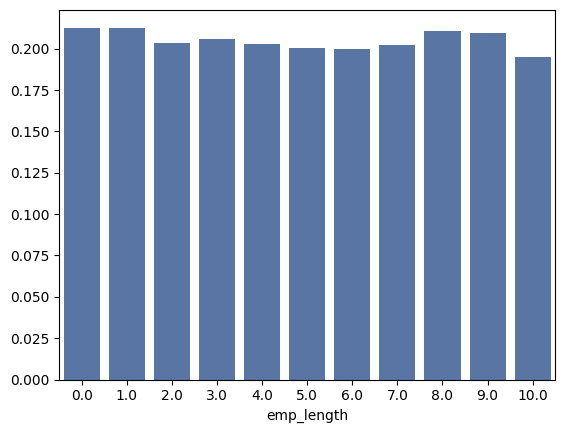

In [22]:
#將emp_length按年份分組統計

#10+ years以10 years計算
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

#< 1 year以0 years計算
dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

#將年份字串都轉為數字
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
 
 #使用df.apply()套用函式emp_length_to_int邏輯傳換df
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)

#用emp_length的值分組，統計各組違約(取1)人數比例
charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]

#以直方圖視覺化
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

平均貸款狀況沒有隨就業年限有太大變化，可將emp_length刪除

In [23]:
#刪除特徵emp_length
dataset.drop(['emp_length'], axis=1, inplace=True)

<Axes: xlabel='sub_grade'>

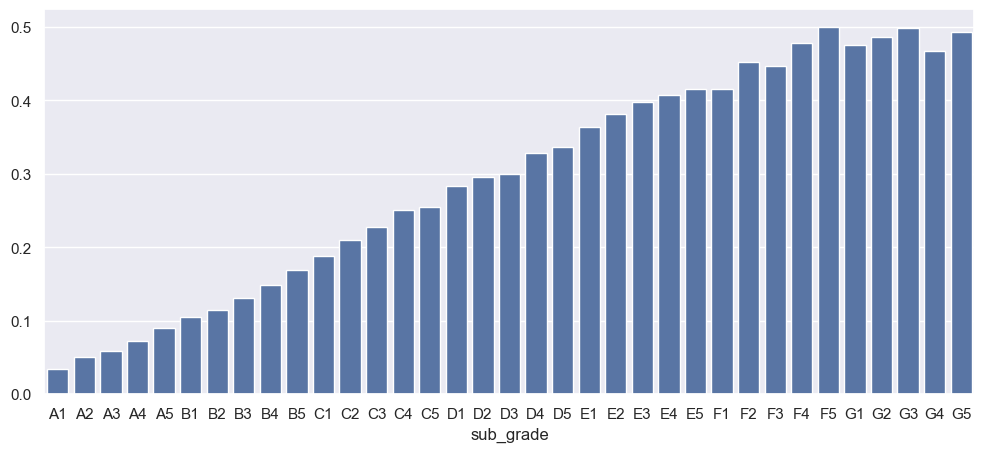

In [24]:
#用sub_grade的值分組，統計各組違約(取1)人數比例
charge_off_rates =dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]

#以直方圖視覺化
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

隨者貸款子級變差，違約可性越高，視為關鍵變數

In [25]:
#查看年收入特徵分布

dataset[['annual_inc']].describe()

,annual_inc
count,8.149860e+05
mean,7.523039e+04
std,6.524373e+04
min,0.000000e+00
25%,4.500000e+04
50%,6.500000e+04
75%,9.000000e+04
max,9.550000e+06


年收入範圍較大，取對數做正規化

In [26]:
#對annual_inc做正規化

#df.apply()套用函式np.log10取對數傳換df
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))

#拿掉舊欄位
dataset.drop('annual_inc', axis=1, inplace=True)

In [27]:
#查看fico_range_low與fico_range_high

dataset[['fico_range_low','fico_range_high']]

,fico_range_low,fico_range_high
0,750.0,754.0
1,710.0,714.0
2,685.0,689.0
4,685.0,689.0
5,680.0,684.0
...,...,...
1646785,690.0,694.0
1646789,660.0,664.0
1646790,665.0,669.0
1646791,660.0,664.0


In [28]:
#查看fico_range_low與fico_range_high相關係數
dataset[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


fico_range_low與fico_range_high相關係數為1，保留1個特徵即可

In [29]:
#fico_range_low與fico_range_high二合為一

#fico_range_low與fico_range_high各取0.5後相加
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']

#刪除原本欄位
dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [34]:
dataset.drop(['id'], axis=1, inplace=True)

## 對分類特徵進行編碼

In [35]:
#對分類資料進行編碼

#標籤編碼器
from sklearn.preprocessing import LabelEncoder

#欄位型別為object時
categorical_feature_mask = dataset.dtypes==object

#取出分類資料(欄位型別為object)的欄位名
categorical_cols = dataset.columns[categorical_feature_mask].tolist()

#標籤編碼器
le = LabelEncoder()

#df.apply()套用標籤編碼器進行編碼傳換df
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))

In [36]:
dataset

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,15000.0,15000.0,60,12.39,336.64,2,10,5,1,2,...,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0,4.892100,752.0
1,10400.0,10400.0,36,6.99,321.08,0,2,1,0,1,...,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,1,4.763435,712.0
2,21425.0,21425.0,60,15.59,516.36,3,15,5,1,1,...,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0,4.804827,687.0
4,7650.0,7650.0,36,13.66,260.20,2,12,5,1,2,...,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,1,4.698979,687.0
5,9600.0,9600.0,36,13.66,326.53,2,12,5,1,2,...,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0,4.838855,682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646785,5000.0,5000.0,36,15.41,174.34,3,15,1,1,2,...,3401.0,341.0,65.9,140.0,14.0,1.0,7.0,1,4.778158,692.0
1646789,6000.0,6000.0,36,26.77,244.22,6,30,5,2,2,...,6499.0,NaN,NaN,99.0,4.0,0.0,3.0,1,4.301052,662.0
1646790,6000.0,6000.0,36,13.67,204.11,2,13,5,2,8,...,1497.0,7311.0,45.0,275.0,4.0,0.0,3.0,0,4.929424,667.0
1646791,24100.0,24100.0,60,18.49,618.43,4,21,5,1,2,...,4590.0,249.0,97.3,195.0,13.0,0.0,5.0,1,4.812920,662.0


In [37]:
#目標變數中79%的全額付清、21%已轉呆帳，假設為非常態分布並進行抽樣，來平衡資料

#取出charged_off為0的所有資料
loanstatus_0 = dataset[dataset["charged_off"]==0]

#取出charged_off為1的所有資料
loanstatus_1 = dataset[dataset["charged_off"]==1]

#charged_off為0的資料隨機抽樣取5500筆
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)

#charged_off為1的資料隨機抽樣取5500筆
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)

#結合兩筆抽樣
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])

#使用df.sample(frac=1)實現shuffle並重置index
dataset = dataset.sample(frac=1).reset_index(drop=True)

#確認看資料大小
print("Current shape of dataset :",dataset.shape)

#查看資料
dataset.head()

Current shape of dataset : (11000, 29)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,21000.0,21000.0,60,21.99,579.88,5,25,5,2,2,...,4717.0,3263.0,57.6,82.0,2.0,0.0,6.0,1,4.812920,677.0
1,10000.0,10000.0,36,14.47,344.07,2,11,5,0,2,...,1566.0,4000.0,89.0,136.0,23.0,0.0,3.0,0,4.681250,662.0
2,9175.0,9175.0,36,17.57,329.73,3,18,1,2,1,...,16351.0,830.0,96.0,285.0,5.0,3.0,8.0,0,4.738788,692.0
3,20000.0,20000.0,60,24.11,576.64,5,26,5,1,9,...,5903.0,210.0,94.2,50.0,4.0,0.0,5.0,0,4.924284,692.0
4,22750.0,22750.0,60,17.14,567.12,4,22,5,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4.707579,702.0


In [38]:
#空值填補

#以平均數填補空值
dataset.fillna(dataset.mean(),inplace = True)

# 模型挑選與評估


## 拆分訓練/測試資料

In [39]:
#拆分訓練/測試資料

#目標變數
Y= dataset["charged_off"]

#自變數
X = dataset.loc[:, dataset.columns != 'charged_off']

#切分比例
validation_size = 0.2

#隨機模式
seed = 7

#使用train_test_split帶入參數切分資料
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## 測試選項與評估指標

In [40]:
#使用10-fold交叉驗證不同模型的績效

#fold次數
num_folds = 10

#隨機模式
seed = 7

#區分二元所以使用roc_auc
scoring = 'roc_auc'


models = []

## 模型比較

In [41]:
#羅吉斯回歸(找到一條線，讓資料可以分成兩類)
models.append(('LR', LogisticRegression()))

#LDA降維(降維後，記計算資料類別的離散程度)
models.append(('LDA', LinearDiscriminantAnalysis()))

#k-nearest neighbors分類(k個最近鄰居分類)
models.append(('KNN', KNeighborsClassifier()))

#決策樹分類(計算熵與不純度)
models.append(('CART', DecisionTreeClassifier()))

#高斯貝氏分類器(特徵為連續變數並符合符合常態分佈時，計算貝式定理(條件機率))
models.append(('NB', GaussianNB()))

In [42]:
#卷積神經網絡

#神經網路
models.append(('NN', MLPClassifier()))

In [43]:
#集成學習


#AdaBoostClassifier(前一個基本分類器分錯的樣本權重會得到加強，加權後的全體樣本再次被用來訓練下一個基本分類器)
models.append(('AB', AdaBoostClassifier()))

#GradientBoostingClassifier(先以弱模型預測。再將先前低度擬合的預測依次增加到集合中，確保錯誤修正)
models.append(('GBM', GradientBoostingClassifier()))

#隨機森林(構建一棵樹的分裂節點的時候，隨機選取特徵)
models.append(('RF', RandomForestClassifier()))

#極端隨機森林(構建一棵樹的分裂節點的時候，不會任意地選取特徵；而是先隨機收集一部分特徵，然後利用信息熵和基尼不
#純性等指標調休最佳的節點特徵)
models.append(('ET', ExtraTreesClassifier()))

In [44]:
#10-fold cv驗證


results = []
names = []
for name, model in models:
    
    #訓練資料_10-fold_rocauc_cv
    kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    
    #cross_val_score
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.911641 (0.007495)
LDA: 0.923771 (0.011021)
KNN: 0.872446 (0.014687)
CART: 0.845928 (0.011335)
NB: 0.925439 (0.009610)
NN: 0.903951 (0.019317)
AB: 0.946567 (0.008032)
GBM: 0.957273 (0.006088)
RF: 0.950425 (0.008460)
ET: 0.942918 (0.010778)


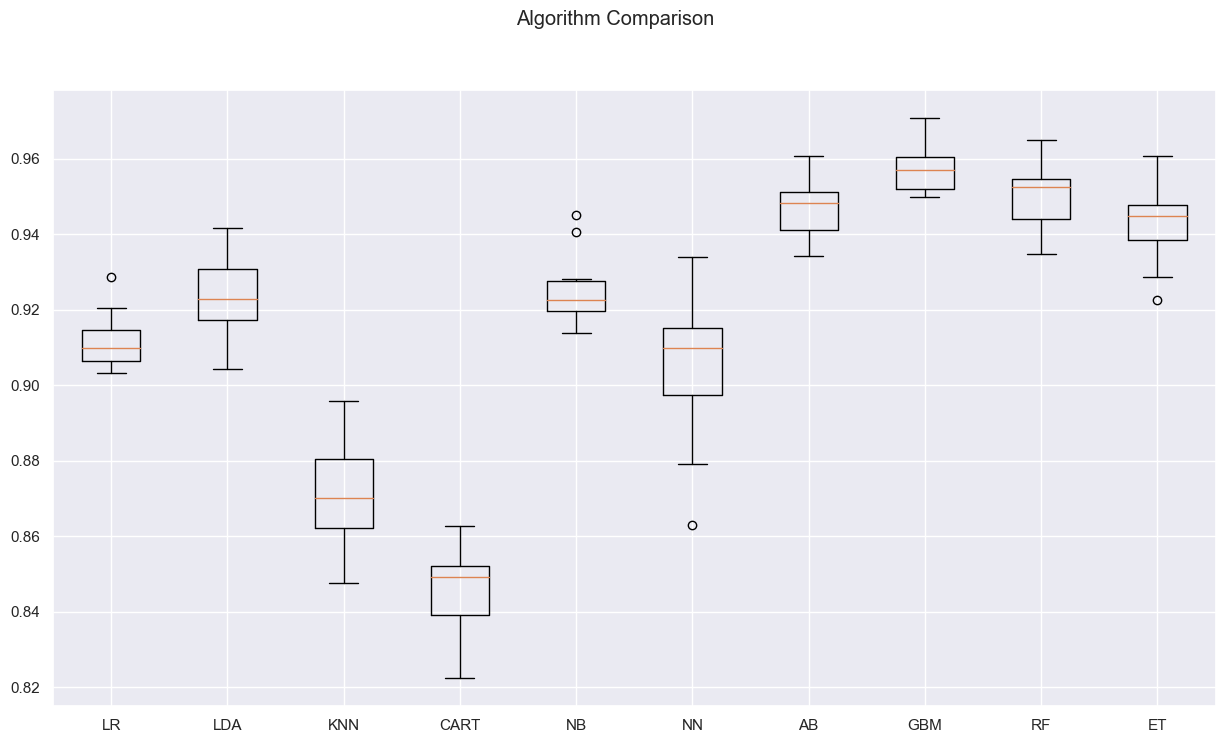

In [46]:
#10-fold cv驗證視覺化

fig = pyplot.figure()

#標題
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

#kfold_results中數據畫合狀圖
pyplot.boxplot(results)

##label名稱
ax.set_xticklabels(names)

#圖片尺寸
fig.set_size_inches(15,8)

pyplot.show()

GBM(梯度提升法)的績效最好，用它做網格搜索

# 模型調教與網格搜尋

In [47]:
#GBM網格搜索

#弱學習器迭代次數
n_estimators = [20,180]

#決策樹最大深度
max_depth= [3,5]

#參數集
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

#GBM模型
model = GradientBoostingClassifier()

#網格搜索
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

#最好參數
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


#參數組合cv平均
means = grid_result.cv_results_['mean_test_score']

#參數組合cv標準差
stds = grid_result.cv_results_['std_test_score']

#參數組合
params = grid_result.cv_results_['params']

#參數組合排名
ranks = grid_result.cv_results_['rank_test_score']

#顯示所有參數集cv分佈
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.960556 using {'max_depth': 5, 'n_estimators': 180}
#4 0.947437 (0.007317) with: {'max_depth': 3, 'n_estimators': 20}
#2 0.960112 (0.005388) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.953078 (0.007729) with: {'max_depth': 5, 'n_estimators': 20}
#1 0.960556 (0.005679) with: {'max_depth': 5, 'n_estimators': 180}


# 模型確立

In [48]:
#用找出的組合訓練模型
model = GradientBoostingClassifier(max_depth= 5, n_estimators= 180)
model.fit(X_train, Y_train)

#模型輸入驗證用變數
predictions = model.predict(X_validation)

#以預測結果及驗證資料計算accuracy_score
print(accuracy_score(Y_validation, predictions))

#以預測結果及驗證資料計算混淆矩陣
print(confusion_matrix(Y_validation, predictions))

#以預測結果及驗證資料計算其他指標
print(classification_report(Y_validation, predictions))


0.8863636363636364
[[956 187]
 [ 63 994]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.88      1143
           1       0.84      0.94      0.89      1057

    accuracy                           0.89      2200
   macro avg       0.89      0.89      0.89      2200
weighted avg       0.89      0.89      0.89      2200



## 測試資料集結果

<Axes: xlabel='Predicted', ylabel='Actual'>

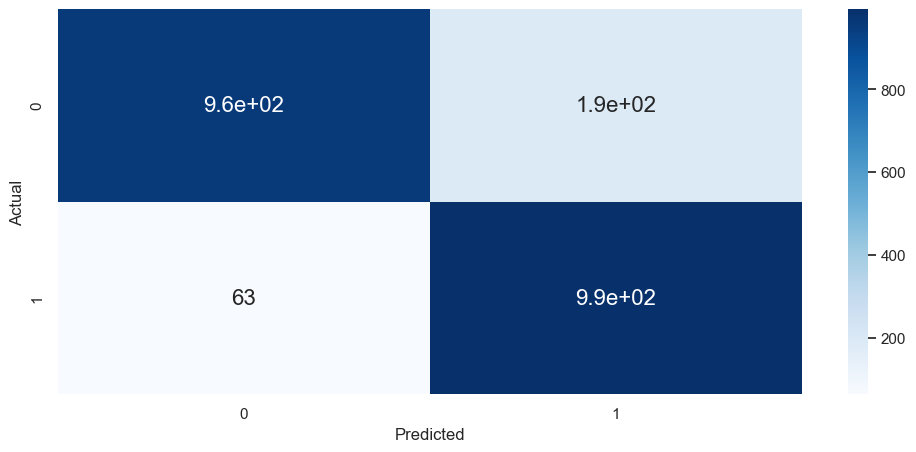

In [49]:
#將混淆矩陣視覺化

#混淆矩陣結果先做成df，np.unique()用來做disuntic後可當x軸y軸指標
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))

#熱力圖X軸指標
df_cm.index.name = 'Actual'

#熱力圖y軸指標
df_cm.columns.name = 'Predicted'

#畫出熱力圖
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes


## 特徵重要性

[4.42932977e-03 7.23140827e-03 2.09263113e-02 1.61661990e-02
 3.16382011e-02 2.27579490e-03 6.94920311e-02 4.86660803e-04
 4.37364694e-03 2.55118855e-03 5.34871725e-03 1.18378269e-02
 5.92110339e-03 3.50825820e-03 7.36270671e-03 6.40638116e-03
 7.32258284e-01 1.36572001e-09 1.03477126e-02 8.68428344e-03
 4.90488932e-03 5.94803175e-03 7.17407142e-03 6.16944031e-03
 3.32504219e-03 3.21084100e-03 8.69103764e-03 9.33059971e-03]


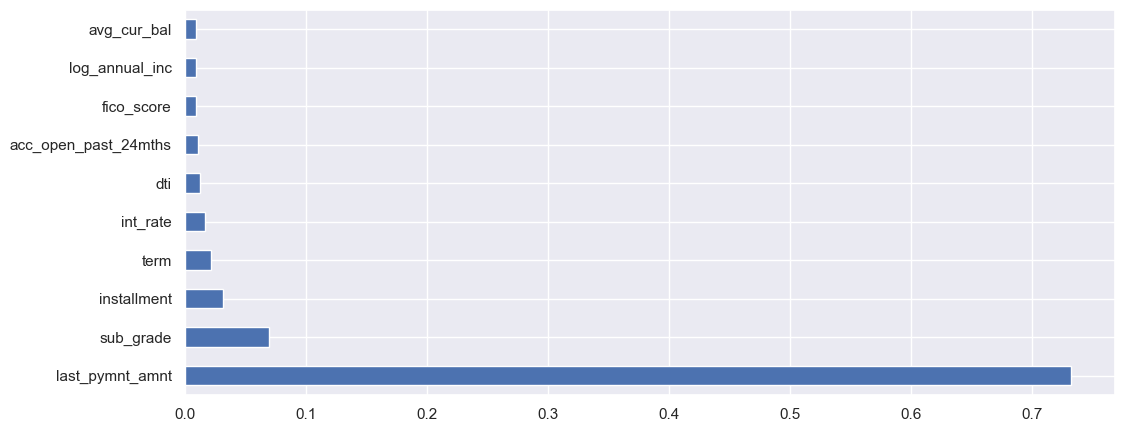

In [50]:
#用訓練完的模型評定各變數的重要性

#各基於分類器重要程度
print(model.feature_importances_)

#將其list轉成series
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

#排序10名後畫出長條圖
feat_importances.nlargest(10).plot(kind='barh')

#畫出圖
pyplot.show()

結果與先前資料探索時的推測相同，last_pymnt_amnt為最重要變數